The main goal of this exercice is to compare different classification methods, applied to the leaf images of kaggle datatset (https://www.kaggle.com/c/leaf-classification/data)
 
I will do it step by step : first the preprocessing, secondly classify with KNN method, then with multiclass SVM, and finally compare the performances of the different models to select the better one.

# 1. Introduction 

Let us fist import, describe, and preprocess the data :

In [1]:
data_path = "~/Documents/openclassroom/Fomation_ingenieur_ML/data/"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## sklearn module : 
from sklearn import model_selection 
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC

### 1. Opening file and Descriptive Analysis:

In [2]:
test_set = pd.read_csv(data_path+"test.csv")
test_set.head(2)

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.0,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.0,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922


In [3]:
df = pd.read_csv(data_path+"Dataset_feuilles_1.csv")
## DROP MISSING VALUES : 
print("there are "+ str(df.isna().sum().sum()) + " missing values, we dropped them." )
df = df.dropna(axis = 0) 
## FIRST LOOK AT THE DATA :
n = df.shape[0]
print("n = "+ str(n) + " and p = " + str(df.shape[1]) ) 
df.head()

there are 0 missing values, we dropped them.
n = 990 and p = 194


,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


To sum up the first information : 
* $y$ is the vector of species, the categrical class to be learnd. There are 99 different species, and 990 individuals in our training set. 

* $X$ is the big matrice, that we can decompose as 
    $$X = \begin{pmatrix} \begin{pmatrix} margin  \\n \times 64  \end{pmatrix} ,
                         & \begin{pmatrix} shape  \\n \times 64  \end{pmatrix} ,
                         & \begin{pmatrix} texture  \\n \times 64  \end{pmatrix}
          \end{pmatrix}$$  
    And each submatrice is numerical. 
    It would be appropriate to first standardize with respect to this stucture (in case there is a big drift between data).

### Classification variable $y$ : 
The categorical $y$ vector is str categories, let's transform it into a number class. The information of translation is save in the "y_str" pandas.DataFrame. 

In [4]:
y_str = df.species
## y values encoder :
from sklearn.preprocessing import LabelEncoder 
my_label_encoder = LabelEncoder()
my_label_encoder.fit(y_str)

y = pd.Series(my_label_encoder.transform(y_str), dtype="category", name="class")
y_str = pd.concat((y_str,pd.Series(y)), axis=1)
# y_str.columns=("species","class")
# y_str.dtype = "category"

print("There are "+str(len(np.unique(y)))+ " different species to classify.")
y_str.head()

There are 99 different species to classify.


,species,class
0,Acer_Opalus,3
1,Pterocarya_Stenoptera,49
2,Quercus_Hartwissiana,65
3,Tilia_Tomentosa,94
4,Quercus_Variabilis,84


### Description Variables $X$ : 

In [5]:
X = df.drop(["id", "species"], axis = 1)
X.describe(include ="all")

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,0.018639,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,0.016071,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,0.005859,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,0.015625,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,0.027344,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,0.097656,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


Let's look a statistical description of the values (of flattened matrices) for "margin", "reshape", and "texture" : 

,margin,shape,texture
count,63360.000000,63360.000000,63360.000000
mean,0.015625,0.000607,0.015625
std,0.021334,0.000302,0.031434
min,0.000000,0.000022,0.000000
25%,0.001953,0.000398,0.000000
50%,0.007812,0.000558,0.003906
75%,0.021484,0.000748,0.018555
max,0.388670,0.003007,0.853520


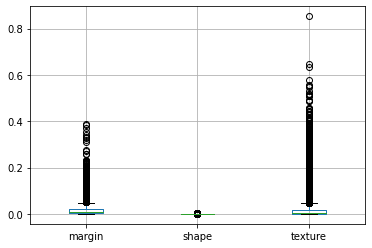

In [6]:
X_decomposed = pd.DataFrame( [X.values.reshape(n,3,64)[:,0,:].flatten(),
                               X.values.reshape(n,3,64)[:,1,:].flatten(),
                               X.values.reshape(n,3,64)[:,2,:].flatten()],
                             index = ["margin","shape","texture"]).T
X_decomposed.boxplot()
X_decomposed.describe()ingredients_from_palm_oil

In this data structure, there is a big drift between the "shape" variable and the others "margin" and "texture" ($\approx \times 100$)

In [7]:
plt.figure(figsize = (8,8))
plt.show()

<Figure size 576x576 with 0 Axes>

Let's see if there are some outliers leaves (individuals) by projecting the X data in a 2-d space, with PCA :

Explained variance ratio : [0.36731316 0.13511645]


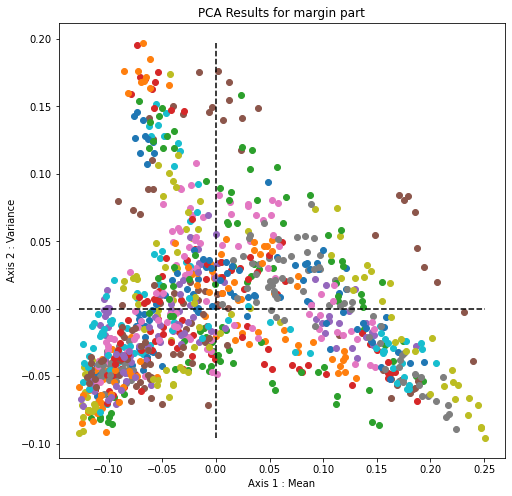

Explained variance ratio : [0.73089031 0.18320153]


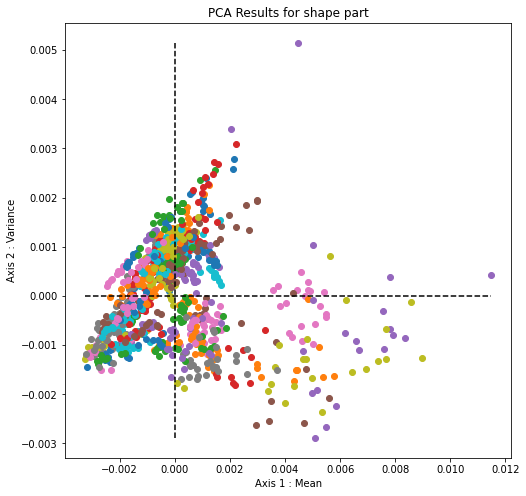

Explained variance ratio : [0.18929111 0.12025495]


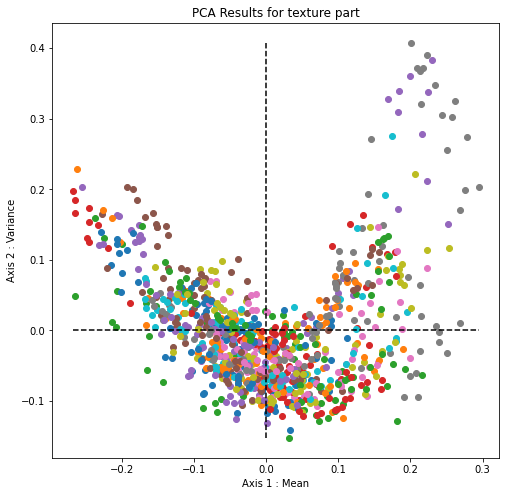

Explained variance ratio : [0.14980004 0.101889  ]


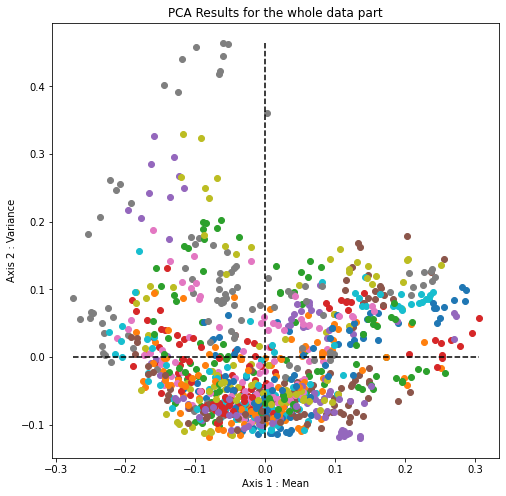

In [8]:
from sklearn.decomposition import PCA
subX = X.values.reshape(n,3,64)[:,0,:]

# from sklearn.preprocessing import StandardScaler
# my_std = preprocessing.StandardScaler()
# my_std.fit(subX)
# subX = my_std.transform(subX)

def plot_pca_submatrix(subX, sub_title=""):
    pca = PCA(n_components=2)
    pca.fit(subX)
    print("Explained variance ratio :", str(pca.explained_variance_ratio_))

    Xpca = pd.concat((y,pd.DataFrame(pca.transform(subX),columns=["ax1","ax2"])),axis=1)
    plt.figure(figsize = (8,8))
    for leaf_class in np.unique(Xpca["class"]):
        tmp = Xpca[Xpca["class"] ==leaf_class]
        plt.scatter(tmp['ax1'],tmp['ax2'], marker="o")
    plt.plot([Xpca["ax1"].min(),Xpca["ax1"].max()], [0,0], linestyle="--", color='black')
    plt.plot([0,0], [Xpca["ax2"].min(),Xpca["ax2"].max()], linestyle="--", color='black')
    plt.Circle([0,0],1,linestyle="--")
    if sub_title == "" :
        plt.title("PCA Results") 
    else :
        plt.title("PCA Results for " + sub_title + " part")
    plt.xlabel("Axis 1 : Mean")
    plt.ylabel("Axis 2 : Variance")
    plt.show()

plot_pca_submatrix(X.values.reshape(n,3,64)[:,0,:],"margin")
plot_pca_submatrix(X.values.reshape(n,3,64)[:,1,:],"shape")
plot_pca_submatrix(X.values.reshape(n,3,64)[:,2,:],"texture")
plot_pca_submatrix(X.values, "the whole data")

It doesn't seem to have some outliers in the data. Let's now standardize each sub-matrix : 

In [9]:
from sklearn.preprocessing import StandardScaler
my_std = preprocessing.StandardScaler()

## STANDARDIZATION ON EACH SUB-MATRIX :
X_std = X.copy()
for k in [0,1,2]:
    subX = X.values.reshape(n,3,64)[:,k,:]
    my_std.fit(subX)
    subX = my_std.transform(subX)
    X_std.iloc[:,k*64:(k+1)*64] = my_std.transform(subX)
    
## AND STANDARDIZATION OF THE GLOBAL X : 
my_std.fit(X_std)
X_std.iloc[:,:] = my_std.transform(X_std)

,margin,shape,texture
count,6.336000e+04,6.336000e+04,6.336000e+04
mean,-7.850062e-19,-5.382900e-18,2.971809e-18
std,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.520978e+00,-2.565864e+00,-1.162301e+00
25%,-6.336042e-01,-6.508590e-01,-5.554379e-01
50%,-3.159489e-01,-1.519546e-01,-3.405698e-01
75%,3.682714e-01,4.617857e-01,1.546105e-01
max,1.475771e+01,7.094418e+00,1.317951e+01


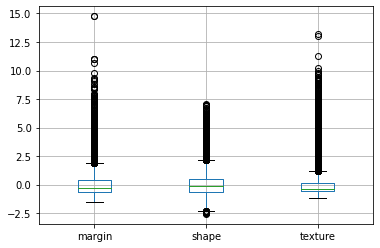

In [10]:
X_decomposed = pd.DataFrame( [X_std.values.reshape(n,3,64)[:,0,:].flatten(),
                               X_std.values.reshape(n,3,64)[:,1,:].flatten(),
                               X_std.values.reshape(n,3,64)[:,2,:].flatten()],
                             index = ["margin","shape","texture"]).T
X_decomposed.boxplot()
X_decomposed.describe()

### Sampling : split train and test data :
Now, let's extract our training and testing samples.

In [133]:
from sklearn.model_selection import train_test_split

y = df.species 
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size = 0.8)

# 2. k-Nearest Neighbors Classification (KNN) : 

In [134]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# knn_param_grid = {"n_neighbors" : np.arange(1,16), "metric" : ["minkowski", "euclidean","manhattan"], "weights" : ["uniform", "distance"]  }
knn_param_grid = {"n_neighbors" : np.arange(1,16), "metric" : ["minkowski", "euclidean","manhattan"], "weights" : ["distance"]  }

CV_knn = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=4)
CV_knn.fit(X_train, y_train)
knn_kwargs = CV_knn.best_params_

print(knn_kwargs)

{'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'distance'}


Let's compare the accuracy of the better parameter grids :

In [135]:
# list_knn_best_kwargs = []
for k in np.argsort(CV_knn.cv_results_["rank_test_score"])[1:7] :
    kwargs = CV_knn.cv_results_["params"][k]
    my_knn = KNeighborsClassifier(**kwargs)
    my_knn.fit(X_train,y_train)
    print("for kwargs = "+ str(kwargs)+
          "\n \t accuracy on test sample = %f 0.4 "%my_knn.score(X_test, y_test))
#     list_knn_best_kwargs.append( )

for kwargs = {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
 	 accuracy on test sample = 0.964646 0.4 
for kwargs = {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
 	 accuracy on test sample = 0.964646 0.4 
for kwargs = {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
 	 accuracy on test sample = 0.964646 0.4 
for kwargs = {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
 	 accuracy on test sample = 0.974747 0.4 
for kwargs = {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
 	 accuracy on test sample = 0.979798 0.4 
for kwargs = {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}
 	 accuracy on test sample = 0.979798 0.4 


# 3. SVM 

## 3.1 with SVC function from sklearn

Let's begin with SVC method, that allows to use a kernel, and a l2 regularisation (hyperparam $C$), and as OVO, and OVR as parameter. That means we can call it immediatly in multiclass : 

Recall : 
* OVR = construct K classifiers (one class VS the K-1 other for each classifier)
* OVO = construct K(K-1) classifiers (one between each class) 

In [139]:
from sklearn.svm import SVC
svm_kwargs = {}#{"kernel" : "linear"}
my_svm = SVC(**svm_kwargs)

param_grid = {"C": np.logspace(-3,4,8),"kernel" : ["linear", 'rbf',"sigmoid"],"decision_function_shape":['ovo','ovr']}

CV_svm = GridSearchCV(my_svm, param_grid, cv =4)
CV_svm.fit(X_train, y_train) 

print("In term of accuracy, there are", 
      sum(CV_svm.cv_results_["rank_test_score"]==1),
      "equivalent best parameter sets")

In term of accuracy, there are 8 equivalent best parameter sets


In [140]:
## CONSTRUCTION OF A FUNCTION TO PLOT THE ROC-CURVE FOR MULTI-CLASS :

# X_train, y_train, X_test, y_test
# classifier = OneVsRestClassifier(SVC(**svm_kwargs))

def plot_ROC_multiclass_classif(X_train, y_train, X_test, y_test, classifier, plot_for_each_classes = False):

    classes = np.unique(y_train.values)
    classifier.fit(X_train, y_train)
    y_score = classifier.decision_function(X_test)

    ## REMOVE CLASSES NOT IN TEST SET : 
    classes2 = [] # list of class with elements in test sample :
    for i in classes:
        if sum(np.where(y_test==i,1,0)) > 0 : 
            classes2.append(i)
        else : 
            print("No individuals from class", i, "in test set")

    # idem : remove columns in y_score that are not in test sample
    y_score2 = y_score[:,np.where(np.in1d(classes,np.array(classes2)))[0]]

    ## COMPUTE TP and FP RATEZS FOR CLASSES IN TEST SAMPLE : 
    FPR = dict()
    TPR = dict()
    flattened_y_true = []
    for i in classes2: 
        i_index = np.where(i in classes2)[0][0]
        y_true = np.where(y_test==i,1,0)
        flattened_y_true = np.concatenate((flattened_y_true,y_true))
        ## COMPUTE ROC :
        FPR[i], TPR[i], _ = roc_curve(y_true = y_true, y_score = y_score2[:,i_index])

    ### ROC ON FPR AND MEAN OF INTERPOLATED TPR CLASS BY CLASS
    FPR_avg, TPR_avg, _ = roc_curve(flattened_y_true, y_score2.ravel())
    FPR_avg_by_class = np.unique(np.concatenate([FPR[i] for i in classes2])) # all classif and misclassif = 828 res
    TPR_avg_by_class = np.zeros_like(FPR_avg_by_class)
    for i in classes2 : #plt.scatter(range(len(all_fpr)), all_fpr)
        TPR_avg_by_class += interp(FPR_avg_by_class, FPR[i], TPR[i])
    TPR_avg_by_class = TPR_avg_by_class/len(classes2)

    ### ROC GLOBAL (FLATTENED DATA)
    FPR_avg_global, TPR_avg_global, _ = roc_curve(flattened_y_true, y_score2.ravel())

    lw = 2
    plt.figure()
    plt.plot(FPR_avg_by_class, TPR_avg_by_class,
             label="micro-average ROC curve (area = %0.2f )"%auc(FPR_avg_by_class, TPR_avg_by_class),
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(FPR_avg_global, TPR_avg_global,
             label="macro-average ROC curve (area = %0.2f )"%auc(FPR_avg_global, TPR_avg_global),
             color='navy', linestyle=':', linewidth=4)
    if plot_for_each_classes : 
        for i in classes2:
            plt.plot(FPR[i],TPR[i])
    ## PLOT PARAM, AXIS, LEGENDS :  
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.legend(loc="lower right")

    plt.show()

No individuals from class Betula_Pendula in test set
No individuals from class Cornus_Chinensis in test set
No individuals from class Lithocarpus_Edulis in test set
No individuals from class Populus_Adenopoda in test set
No individuals from class Quercus_Afares in test set
No individuals from class Quercus_Castaneifolia in test set
No individuals from class Quercus_Coccinea in test set
No individuals from class Quercus_Nigra in test set
No individuals from class Tilia_Tomentosa in test set
No individuals from class Zelkova_Serrata in test set


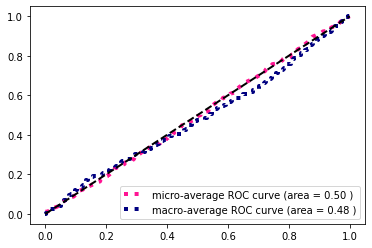

No individuals from class Betula_Pendula in test set
No individuals from class Cornus_Chinensis in test set
No individuals from class Lithocarpus_Edulis in test set
No individuals from class Populus_Adenopoda in test set
No individuals from class Quercus_Afares in test set
No individuals from class Quercus_Castaneifolia in test set
No individuals from class Quercus_Coccinea in test set
No individuals from class Quercus_Nigra in test set
No individuals from class Tilia_Tomentosa in test set
No individuals from class Zelkova_Serrata in test set


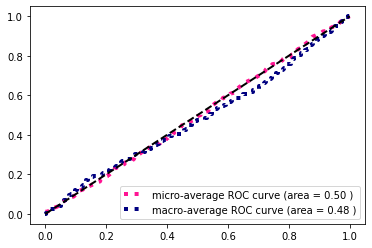

No individuals from class Betula_Pendula in test set
No individuals from class Cornus_Chinensis in test set
No individuals from class Lithocarpus_Edulis in test set
No individuals from class Populus_Adenopoda in test set
No individuals from class Quercus_Afares in test set
No individuals from class Quercus_Castaneifolia in test set
No individuals from class Quercus_Coccinea in test set
No individuals from class Quercus_Nigra in test set
No individuals from class Tilia_Tomentosa in test set
No individuals from class Zelkova_Serrata in test set


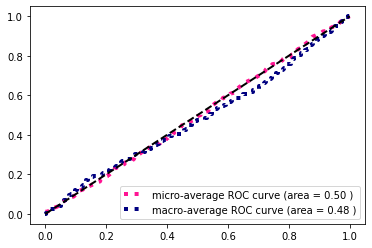

No individuals from class Betula_Pendula in test set
No individuals from class Cornus_Chinensis in test set
No individuals from class Lithocarpus_Edulis in test set
No individuals from class Populus_Adenopoda in test set
No individuals from class Quercus_Afares in test set
No individuals from class Quercus_Castaneifolia in test set
No individuals from class Quercus_Coccinea in test set
No individuals from class Quercus_Nigra in test set
No individuals from class Tilia_Tomentosa in test set
No individuals from class Zelkova_Serrata in test set


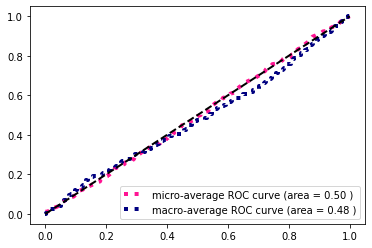

No individuals from class Betula_Pendula in test set
No individuals from class Cornus_Chinensis in test set
No individuals from class Lithocarpus_Edulis in test set
No individuals from class Populus_Adenopoda in test set
No individuals from class Quercus_Afares in test set
No individuals from class Quercus_Castaneifolia in test set
No individuals from class Quercus_Coccinea in test set
No individuals from class Quercus_Nigra in test set
No individuals from class Tilia_Tomentosa in test set
No individuals from class Zelkova_Serrata in test set


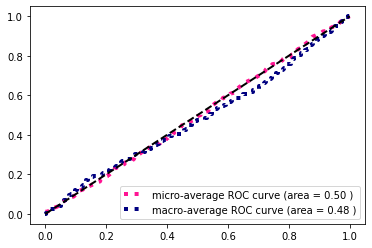

No individuals from class Betula_Pendula in test set
No individuals from class Cornus_Chinensis in test set
No individuals from class Lithocarpus_Edulis in test set
No individuals from class Populus_Adenopoda in test set
No individuals from class Quercus_Afares in test set
No individuals from class Quercus_Castaneifolia in test set
No individuals from class Quercus_Coccinea in test set
No individuals from class Quercus_Nigra in test set
No individuals from class Tilia_Tomentosa in test set
No individuals from class Zelkova_Serrata in test set


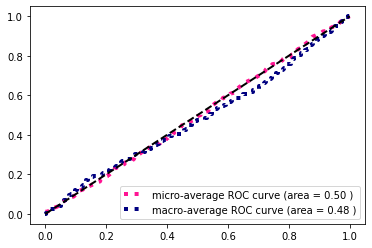

No individuals from class Betula_Pendula in test set
No individuals from class Cornus_Chinensis in test set
No individuals from class Lithocarpus_Edulis in test set
No individuals from class Populus_Adenopoda in test set
No individuals from class Quercus_Afares in test set
No individuals from class Quercus_Castaneifolia in test set
No individuals from class Quercus_Coccinea in test set
No individuals from class Quercus_Nigra in test set
No individuals from class Tilia_Tomentosa in test set
No individuals from class Zelkova_Serrata in test set


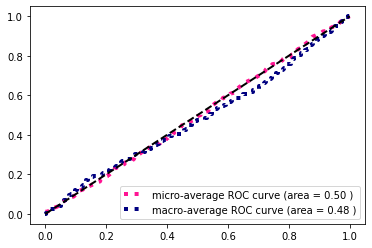

No individuals from class Betula_Pendula in test set
No individuals from class Cornus_Chinensis in test set
No individuals from class Lithocarpus_Edulis in test set
No individuals from class Populus_Adenopoda in test set
No individuals from class Quercus_Afares in test set
No individuals from class Quercus_Castaneifolia in test set
No individuals from class Quercus_Coccinea in test set
No individuals from class Quercus_Nigra in test set
No individuals from class Tilia_Tomentosa in test set
No individuals from class Zelkova_Serrata in test set


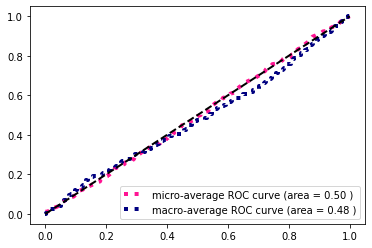

In [141]:
# list_knn_best_kwargs = []
from sklearn.metrics import roc_curve, auc

sorting_index = np.where(CV_svm.cv_results_["rank_test_score"]==1)[0]
## note that we could have chosen the 8 bests with : np.argsort(CV_svm.cv_results_["rank_test_score"][::-1][-8:])
for k in sorting_index :
    kwargs = CV_svm.cv_results_["params"][k]
    classifier = OneVsRestClassifier(SVC(**kwargs))
    plot_ROC_multiclass_classif(X_train, y_train, X_test, y_test, classifier, plot_for_each_classes = False)


## 3.2. SGDClassifier and Linear SVC : 
LinearSVC did not converge with "dual = False" (error "Liblinear failed to converge, increase ") and it is not possible to set an hinge or l1 with "dual = True". Let's try with the " SGDClassifier" : 

In [164]:
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import SGDClassifier

# svm_kwargs = {"penalty":"elasticnet", "max_iter":1000}
# my_svm = SGDClassifier(**svm_kwargs)
# param_grid = {"alpha": np.logspace(-4,4,9), "l1_ratio":0.1*np.arange(0,11,1),
#              "loss": ["hinge", "log","modified_huber", "squared_hinge","perceptron"]}
# CV_svm = GridSearchCV(my_svm, param_grid, cv = 4)
# CV_svm.fit(X_train, y_train) 

/home/claire/Applications/python/conda/envs/openclassroom/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/claire/Applications/python/conda/envs/openclassroom/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/claire/Applications/python/conda/envs/openclassroom/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/claire/Applications/pytho

/home/claire/Applications/python/conda/envs/openclassroom/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/claire/Applications/python/conda/envs/openclassroom/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/claire/Applications/python/conda/envs/openclassroom/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/claire/Applications/pytho

GridSearchCV(cv=4, estimator=SGDClassifier(penalty='elasticnet'),
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'loss': ['hinge', 'log', 'modified_huber',
                                  'squared_hinge', 'perceptron']})

It is really long to run, and there is a repeated error message : 
``` /home/claire/Applications/python/conda/envs/openclassroom/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before " ```

In [169]:
# np.save("CV_svm_results.npy",CV_svm.cv_results_)

In term of accuracy, there are 1 equivalent best parameter sets
No individuals from class Betula_Pendula in test set
No individuals from class Cornus_Chinensis in test set
No individuals from class Lithocarpus_Edulis in test set
No individuals from class Populus_Adenopoda in test set
No individuals from class Quercus_Afares in test set
No individuals from class Quercus_Castaneifolia in test set
No individuals from class Quercus_Coccinea in test set
No individuals from class Quercus_Nigra in test set
No individuals from class Tilia_Tomentosa in test set
No individuals from class Zelkova_Serrata in test set


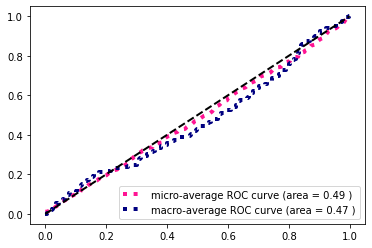

In [172]:
sorting_index = np.where(CV_svm.cv_results_["rank_test_score"]==1)[0]
print("In term of accuracy, there are", 
      sum(CV_svm.cv_results_["rank_test_score"]==1),
      "equivalent best parameter sets")
## note that we could have chosen the 8 bests with : np.argsort(CV_svm.cv_results_["rank_test_score"][::-1][-8:])
for k in sorting_index :
    kwargs = CV_svm.cv_results_["params"][k]
    classifier = SGDClassifier(**kwargs, max_iter = 10000)
    plot_ROC_multiclass_classif(X_train, y_train, X_test, y_test, classifier, plot_for_each_classes = False)

In [168]:
CV_svm.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.1, 'loss': 'perceptron'}

# 4. Ideas to better the problem : 
* Cluster species as a first step and use it as a pre-selection
* Use random forests